# Tomo Challenge Sandbox

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import tc

Found classifier Random
Found classifier RandomForest
Found classifier IBandOnly


## Challenge Data

In [19]:
bands='riz'

training_file=f'/media/data2/tomo_challenge_data/ugrizy/training.hdf5'
validation_file=f'/media/data2/tomo_challenge_data/ugrizy/validation.hdf5'

include_colors=True
include_errors=True

In [20]:
train_data_arr = tc.load_data(training_file, bands, 
                             errors=include_errors,
                             colors=include_errors, array=True)
training_z = tc.load_redshift(training_file)

In [26]:
train_data_arr.shape

(8615613, 12)

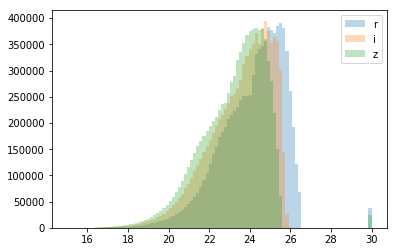

In [31]:
for band, idx in zip(bands, (0, 1, 2)):
    plt.hist(train_data_arr[:, idx], bins=np.linspace(15, 30, 100), label=band, alpha=0.3)
plt.legend();

In [34]:
valid_data_arr = tc.load_data(validation_file, bands, 
                              errors=include_errors,
                              colors=include_errors, array=True)

val_z = tc.load_redshift(validation_file)

In [35]:
valid_data_arr.shape

(17228554, 12)

## Random Forest Example

In [32]:
classifier = tc.Tomographer._find_subclass('RandomForest')(bands, {'bins': 4})

In [33]:
classifier.train(train_data_arr[:20000], training_z[:20000])

Finding bins for training data
Fitting classifier


/opt/anaconda3/envs/ML/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
nvalidate = 50000
results = classifier.apply(valid_data_arr[:nvalidate])

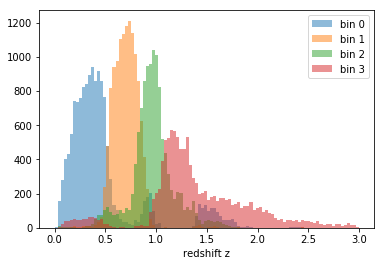

In [40]:
plt.hist(val_z[:nvalidate][results == 0.],100,alpha=0.5,range=[0,3], label='bin 0');
plt.hist(val_z[:nvalidate][results == 1.],100,alpha=0.5,range=[0,3], label='bin 1');
plt.hist(val_z[:nvalidate][results == 2.],100,alpha=0.5,range=[0,3], label='bin 2');
plt.hist(val_z[:nvalidate][results == 3.],100,alpha=0.5,range=[0,3], label='bin 3');
plt.legend();
plt.xlabel('redshift z');

## Jax-Cosmo Metrics

In [44]:
%time scores = tc.jc_compute_scores(results, val_z[:nvalidate], metrics=['SNR_3x2', 'FOM_3x2', 'FOM_DETF_3x2'])

CPU times: user 1min 1s, sys: 3.31 s, total: 1min 5s
Wall time: 59.1 s


In [45]:
scores

{'SNR_3x2': 1183.6251220703125,
 'FOM_3x2': 2072.68798828125,
 'FOM_DETF_3x2': 46.409053802490234}

In [46]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


## Jax-Cosmo Calculations

In [57]:
import jax
import jax_cosmo as jc
import jax_cosmo.sparse as sparse

In [52]:
tomo_bin = jax.nn.one_hot(results, results.max() + 1)

probes = tc.jax_metrics.get_probes(tomo_bin, val_z[:nvalidate], what='3x2')
ell, delta_ell = tc.jax_metrics.ell_binning()

In [50]:
cosmo = jc.Cosmology(
    Omega_c = 0.27,
    Omega_b = 0.045,
    h = 0.67,
    n_s = 0.96,
    sigma8 = 0.8404844953840714,
    Omega_k=0.,
    w0=-1., wa=0.)

In [53]:
%time mu, C = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes, f_sky=0.25, nonlinear_fn=jc.power.halofit, sparse=True)

/opt/anaconda3/envs/ML/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 7.57 s, sys: 1.34 s, total: 8.91 s
Wall time: 10.8 s


In [58]:
mu.shape, C.shape, sparse.is_sparse(C)

((3600,), (36, 36, 100), True)

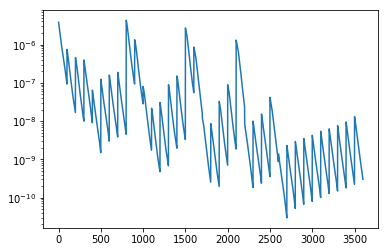

In [55]:
plt.semilogy(mu, '-');

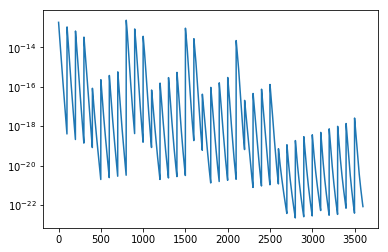

In [63]:
plt.semilogy(np.diag(sparse.to_dense(C)), '-');

## Formalism

Each combination, indexed by $i$, of a probe P_i (WL, number density, etc) and a redshift bin with normalized density $dn_i/dz(z)$ has an associated kernel function $K_i(a, \ell)$. The power spectrum associated with the pair $(i,j)$ is:
$$
c_{i,j}(\ell) = \frac{1}{c^2} \int_0^1 da K_i(a, \ell) K_j(a, \ell) F(a, \ell)
$$
where $F$ depends on the assumed cosmology but not on $i$ or $j$:
$$
F(a, \ell) = P_{NL}\left(\frac{\ell + 1/2}{\chi(a)}, a\right) \frac{1}{\chi(a)^2} \frac{d\chi}{da}(a) \; .
$$

The kernel is linear in the normalized density so if we combine two redshift bins $a + b \rightarrow ab$ according to
$$
\frac{dn_{ab}}{dz}(z) = \alpha \frac{dn_{a}}{dz}x(z) + \beta \frac{dn_{b}}{dz}(z) \; ,
$$
with $\alpha + \beta = 1$, then
$$
K_{ab}(a, \ell) = \alpha K_a(a, \ell) + \beta K_b(a, \ell)
$$
and
$$
c_{ab,j}(\ell) = \frac{1}{c^2} \int_0^1 da \left[ \alpha K_a(a, \ell) + \beta K_b(a, \ell) \right] K_j(a, \ell) F(a, \ell)
= \alpha c_{a,j}(\ell) + \beta c_{b,j}(\ell) \; .
$$